In [5]:
import pandas as pd
import numpy as np

movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")
tags = pd.read_csv("tags.csv")
links = pd.read_csv("links.csv")


In [6]:
# Kiểm tra cấu trúc của các DataFrame
print("\nMovies:")
print(movies.info())
print(movies.head())

print("\nRatings:")
print(ratings.info())
print(ratings.head())

print("\nTags:")
print(tags.info())
print(tags.head())

print("\nLinks:")
print(links.info())
print(links.head())



Movies:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings:
<class 'pandas.core.frame.DataFrame'>


In [7]:
# Kiểm tra giá trị bị thiếu
print("\nMissing values in Movies:")
print(movies.isnull().sum())

print("\nMissing values in Ratings:")
print(ratings.isnull().sum())

print("\nMissing values in Tags:")
print(tags.isnull().sum())

print("\nMissing values in Links:")
print(links.isnull().sum())

# Xử lý giá trị bị thiếu
movies['genres'] = movies['genres'].fillna("Unknown")  # Thay thế thể loại bị thiếu bằng "Unknown"
tags = tags.dropna(subset=['tag'])  # Xóa các hàng trong tags có giá trị Null ở cột tag
links = links.fillna(-1)  # Thay giá trị thiếu ở links bằng -1



Missing values in Movies:
movieId    0
title      0
genres     0
dtype: int64

Missing values in Ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing values in Tags:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

Missing values in Links:
movieId    0
imdbId     0
tmdbId     8
dtype: int64


In [8]:
# Gộp movies và ratings
movies_ratings = pd.merge(ratings, movies, on="movieId", how="inner")

# Gộp thêm dữ liệu từ tags (nếu cần)
movies_ratings_tags = pd.merge(movies_ratings, tags, on=["movieId", "userId"], how="left")

# Kiểm tra kết quả sau khi gộp
print("\nMovies-Ratings-Tags combined:")
print(movies_ratings_tags.info())
print(movies_ratings_tags.head())



Movies-Ratings-Tags combined:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102677 entries, 0 to 102676
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userId       102677 non-null  int64  
 1   movieId      102677 non-null  int64  
 2   rating       102677 non-null  float64
 3   timestamp_x  102677 non-null  int64  
 4   title        102677 non-null  object 
 5   genres       102677 non-null  object 
 6   tag          3476 non-null    object 
 7   timestamp_y  3476 non-null    float64
dtypes: float64(2), int64(3), object(3)
memory usage: 6.3+ MB
None
   userId  movieId  rating  timestamp_x                        title  \
0       1        1     4.0    964982703             Toy Story (1995)   
1       1        3     4.0    964981247      Grumpier Old Men (1995)   
2       1        6     4.0    964982224                  Heat (1995)   
3       1       47     5.0    964983815  Seven (a.k.a. Se7en) (1995)   
4 

In [9]:
# Tính rating trung bình cho mỗi phim
average_ratings = movies_ratings.groupby('movieId')['rating'].mean().reset_index()
average_ratings = average_ratings.rename(columns={'rating': 'average_rating'})

# Gộp với movies để có thông tin thể loại
movies_with_avg_ratings = pd.merge(movies, average_ratings, on='movieId', how='inner')

# Lọc các phim có rating trung bình > 4.0 và thuộc thể loại 'Action'
filtered_movies = movies_with_avg_ratings[
    (movies_with_avg_ratings['average_rating'] > 4.0) &
    (movies_with_avg_ratings['genres'].str.contains('Action'))
]

print("\nFiltered movies (Action genre with average rating > 4.0):")
print(filtered_movies.head())



Filtered movies (Action genre with average rating > 4.0):
     movieId                                              title  \
97       110                                  Braveheart (1995)   
224      260          Star Wars: Episode IV - A New Hope (1977)   
246      284            New York Cop (Nyû Yôku no koppu) (1993)   
254      293  Léon: The Professional (a.k.a. The Professiona...   
474      541                                Blade Runner (1982)   

                          genres  average_rating  
97              Action|Drama|War        4.031646  
224      Action|Adventure|Sci-Fi        4.231076  
246                 Action|Crime        4.500000  
254  Action|Crime|Drama|Thriller        4.018797  
474       Action|Sci-Fi|Thriller        4.100806  


In [10]:
# Tách thể loại (genres) thành danh sách
movies['genres_list'] = movies['genres'].str.split('|')

# Tạo bảng thống kê bằng cách "explode" thể loại
movies_exploded = movies.explode('genres_list')
genre_stats = movies_exploded.merge(average_ratings, on='movieId')
genre_stats = genre_stats.groupby('genres_list').agg(
    num_movies=('movieId', 'count'),
    avg_rating=('average_rating', 'mean')
).reset_index()

print("\nGenre statistics:")
print(genre_stats)



Genre statistics:
           genres_list  num_movies  avg_rating
0   (no genres listed)          34    3.371148
1               Action        1828    3.094498
2            Adventure        1262    3.215230
3            Animation         610    3.497119
4             Children         664    3.107690
5               Comedy        3753    3.181716
6                Crime        1196    3.301844
7          Documentary         438    3.781682
8                Drama        4349    3.420905
9              Fantasy         778    3.218843
10           Film-Noir          85    3.670471
11              Horror         977    2.918965
12                IMAX         158    3.311996
13             Musical         333    3.296371
14             Mystery         573    3.330364
15             Romance        1591    3.364870
16              Sci-Fi         980    3.102637
17            Thriller        1889    3.156116
18                 War         381    3.571655
19             Western         167    3.3

In [11]:
# Chuyển đổi timestamp thành DateTime
ratings['parsed_time'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Thêm cột năm và tháng
ratings['year'] = ratings['parsed_time'].dt.year
ratings['month'] = ratings['parsed_time'].dt.month

# Tính số lượng đánh giá theo năm
ratings_per_year = ratings.groupby('year').size().reset_index(name='num_ratings')

print("\nNumber of ratings per year:")
print(ratings_per_year)



Number of ratings per year:
    year  num_ratings
0   1996         6040
1   1997         1916
2   1998          507
3   1999         2439
4   2000        10061
5   2001         3922
6   2002         3478
7   2003         4014
8   2004         3279
9   2005         5813
10  2006         4059
11  2007         7114
12  2008         4351
13  2009         4158
14  2010         2301
15  2011         1690
16  2012         4656
17  2013         1664
18  2014         1439
19  2015         6616
20  2016         6703
21  2017         8198
22  2018         6418


C:\Users\PC VY\AppData\Local\Temp\ipykernel_25948\3107976253.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='year', y='num_ratings', data=ratings_per_year, palette='viridis')


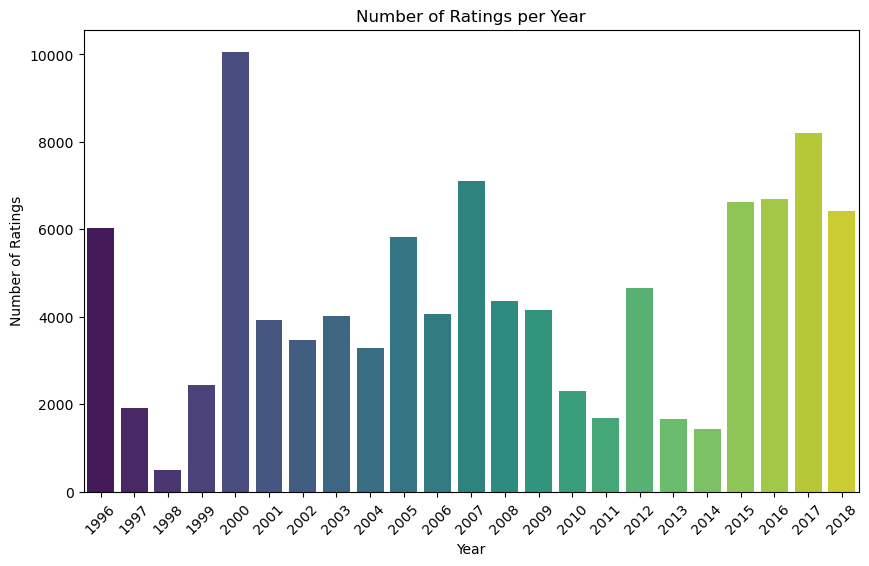

C:\Users\PC VY\AppData\Local\Temp\ipykernel_25948\3107976253.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_rating', y='genres_list', data=genre_stats.sort_values('avg_rating', ascending=False), palette='coolwarm')


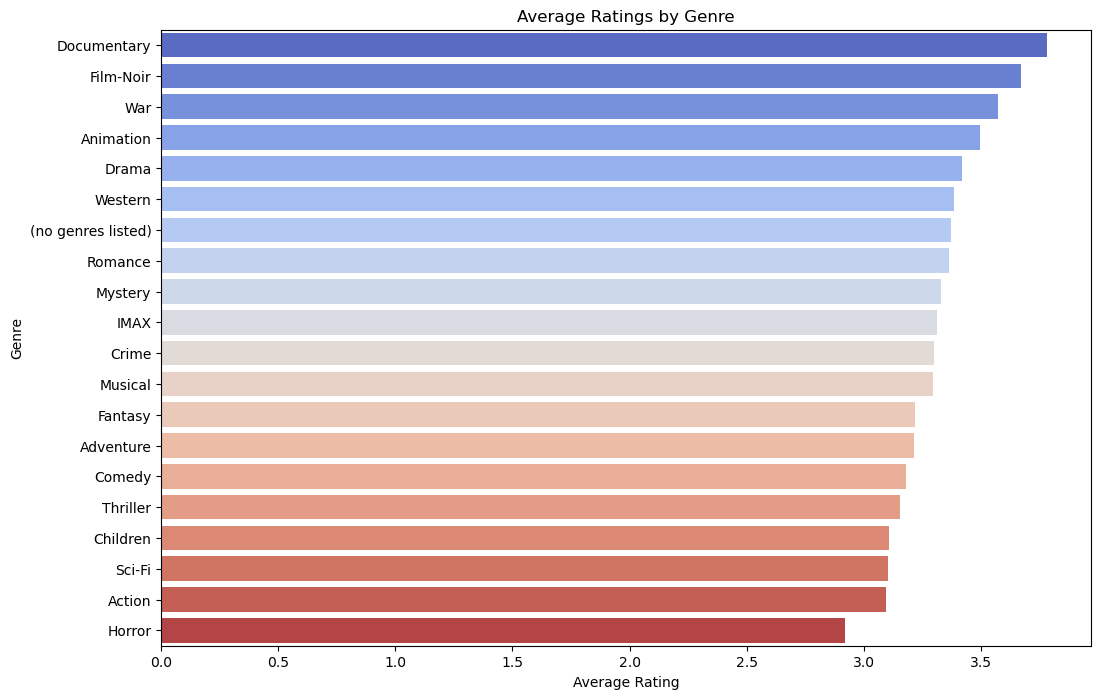

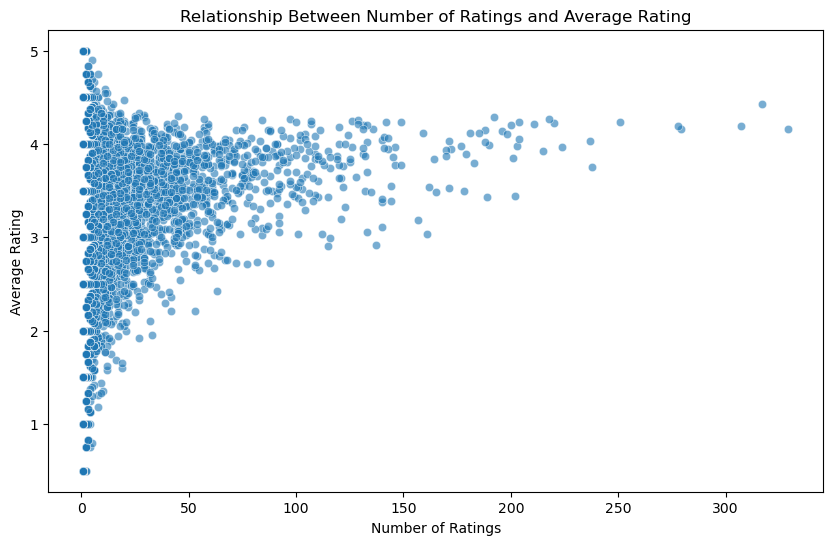

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Vẽ số lượng đánh giá theo năm
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='num_ratings', data=ratings_per_year, palette='viridis')
plt.title('Number of Ratings per Year')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.show()

# Vẽ trung bình rating theo thể loại
plt.figure(figsize=(12, 8))
sns.barplot(x='avg_rating', y='genres_list', data=genre_stats.sort_values('avg_rating', ascending=False), palette='coolwarm')
plt.title('Average Ratings by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.show()

# Tính số lượng rating cho mỗi phim
num_ratings = movies_ratings.groupby('movieId')['rating'].count().reset_index()
num_ratings = num_ratings.rename(columns={'rating': 'num_ratings'})

# Gộp với rating trung bình
ratings_analysis = pd.merge(average_ratings, num_ratings, on='movieId', how='inner')

# Vẽ mối quan hệ giữa số lượng rating và rating trung bình
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_ratings', y='average_rating', data=ratings_analysis, alpha=0.6)
plt.title('Relationship Between Number of Ratings and Average Rating')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.show()
